# Notebook to generate the plots for the paper

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [3]:
import seaborn as sns

In [4]:
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

### Custom Modules

In [5]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [6]:
import gmac

In [7]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
# plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [8]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations_am(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

## Read the Controls and Patients Data

In [10]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

## Read the Pitch and Accl. Mag. Estimation files

In [11]:
basedir = "../data/output"

# Read pitch parameters.
with open(pathlib.Path(basedir, "pitch", "pitch_params.json"), "r") as f:
    pitch_param_ranges = json.load(f)

# Read am parameters.
with open(pathlib.Path(basedir, "am", "am_params.json"), "r") as f:
    am_param_ranges = json.load(f)

# Read gmac parameters.
with open(pathlib.Path(basedir, "gmac", "gmac_params.json"), "r") as f:
    gmac_param_ranges = json.load(f)

In [12]:
# Read pitch, gm, and gmac performance file
pitch_perf = pd.read_csv(pathlib.Path(basedir, "pitch", "perf_pitch_est.csv"))
am_perf = pd.read_csv(pathlib.Path(basedir, "am", "perf_am_est.csv"))
gmac_perf = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac.csv"))
gmac_perf_intra = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac_intra.csv"))

## Read Subash et 2022 results file

In [13]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

In [14]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
subash_perf_gmac = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "GMAC"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intersubject
subash_perf_rfinter = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF inter"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject
subash_perf_rfintra = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject mean
subash_perf_rfintra_mean = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

## Overall Summary: Pitch and AM

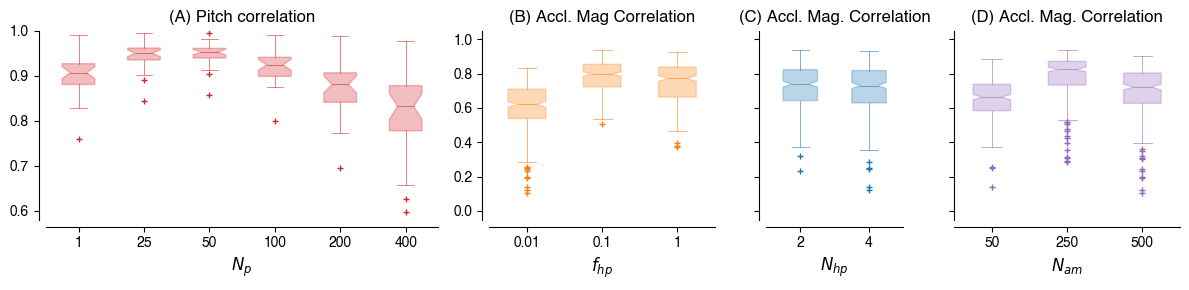

In [207]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, height_ratios=[1], width_ratios=[2, 1.15, 0.7, 1.15])

# Pitch performance
ax = plt.subplot(gs[0, 0])
for i, _np in enumerate(pitch_param_ranges["np"]):
    # print(np.sum(pitch_perf.np == _np))
    ax.boxplot(x=pitch_perf[pitch_perf.np == _np]["corr"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_title(r"(A) Pitch correlation", fontsize=12)
ax.set_ylim((0.58, 1))
ax.set_xlabel(r"$N_p$", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

# Correlation coefficient vs. fc
ax = plt.subplot(gs[0, 1])
for i, _val in enumerate(am_param_ranges["fc"]):
    ax.boxplot(x=am_perf[am_perf.fc == _val]["r"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:orange", color="tab:orange", alpha=0.3),
               capprops=dict(color="tab:orange", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:orange", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:orange", markeredgecolor="tab:orange",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:orange", alpha=0.8, lw=0.5))
ax.set_xticklabels(am_param_ranges["fc"], fontsize=12);
ax.set_title(r"(B) Accl. Mag Correlation", fontsize=12)
ax.set_ylim((-0.05, 1.05))
ax.set_xlabel(r"$f_{hp}$", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

# Correlation coefficient vs. Nc
ax = plt.subplot(gs[0, 2])
for i, _val in enumerate(am_param_ranges["nc"]):
    ax.boxplot(x=am_perf[am_perf.nc == _val]["r"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:blue", color="tab:blue", alpha=0.3),
               capprops=dict(color="tab:blue", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:blue", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:blue", markeredgecolor="tab:blue",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:blue", alpha=0.8, lw=0.5))
ax.set_xticklabels(am_param_ranges["nc"], fontsize=12);
ax.set_title(r"(C) Accl. Mag. Correlation", fontsize=12)
ax.set_ylim((-0.05, 1.05))
ax.set_xlabel(r"$N_{hp}$", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.set_yticklabels([])
ax.spines['bottom'].set_position(('outward', 5))

# Correlation coefficient vs. Nam
ax = plt.subplot(gs[0, 3])
for i, _val in enumerate(am_param_ranges["nam"]):
    ax.boxplot(x=am_perf[am_perf.nam == _val]["r"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:purple", color="tab:purple", alpha=0.3),
               capprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:purple", markeredgecolor="tab:purple",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:purple", alpha=0.8, lw=0.5))
ax.set_xticklabels(am_param_ranges["nam"], fontsize=12);
ax.set_title(r"(D) Accl. Mag. Correlation", fontsize=12)
ax.set_ylim((-0.05, 1.05))
ax.set_xlabel(r"$N_{am}$", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(basedir, f"pitch_am_params_perf.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"pitch_am_params_perf.svg"), bbox_inches="tight")

### Statistical analysis of factors

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Pitch comparison across Np parameter values

In [24]:
pitch_df = pitch_perf[["subject", "limb", "np", "err", "corr"]].reset_index(drop=True)
limb_weight = {
    "left": 0,
    "right": 10,
    "aff": 20,
    "unaff": 25
}
pitch_df["subjid"] = int(0)
for _row in pitch_perf.iterrows():
    pitch_df.loc[_row[0], "subjid"] = limb_weight[_row[1]["limb"]] + _row[1]["subject"]
pitch_df["np"] = pitch_df["np"].astype(int)
pitch_df["err"] = pitch_df["err"].astype(float)
pitch_df["corr"] = pitch_df["corr"].astype(float)
pitch_df["subjid"] = pitch_df["subjid"].astype(int)
lme_pitch = smf.mixedlm("corr ~ np", data=pitch_df, groups=pitch_df["subjid"])
lme_pitch.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: corr    
No. Observations: 180     Method:             REML    
No. Groups:       30      Scale:              0.0013  
Min. group size:  6       Log-Likelihood:     297.0846
Max. group size:  6       Converged:          Yes     
Mean group size:  6.0                                 
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   0.939    0.008 111.608 0.000  0.922  0.955
np         -0.000    0.000 -15.368 0.000 -0.000 -0.000
Group Var   0.002    0.015                            
======================================================

"""

### AM comparison across fc, Nc, Nam parameter values

In [25]:
am_df = am_perf[["subject", "fc", "nc", "nam", "r"]].reset_index(drop=True)
limb_weight = {
    "left": 0,
    "right": 10,
    "aff": 20,
    "unaff": 25
}
am_df["subjid"] = int(0)
for _row in am_perf.iterrows():
    am_df.loc[_row[0], "subjid"] = limb_weight[_row[1]["limb"]] + _row[1]["subject"]
am_df["nc"] = am_df["nc"].astype(int)
am_df["fc"] = am_df["fc"].astype(float)
am_df["nam"] = am_df["nam"].astype(int)
am_df["r"] = am_df["r"].astype(float)
am_df["subjid"] = am_df["subjid"].astype(int)
lme_am = smf.mixedlm("r ~ fc + nc + nam", data=am_df, groups=am_df["subjid"])
lme_am.fit(method='bfgs').summary()


/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 810     Method:             REML    
No. Groups:       30      Scale:              0.0120  
Min. group size:  27      Log-Likelihood:     579.1985
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.659    0.019 34.913 0.000  0.622  0.696
fc           0.066    0.009  7.640 0.000  0.049  0.083
nc           0.002    0.003  0.777 0.437 -0.004  0.008
nam          0.000    0.000  3.869 0.000  0.000  0.000
Group Var    0.007    0.019                           
======================================================

"""

## GMAC Performance: Inter-Subject without validation

In [209]:
# Generate data for heatmap
# Get performance for the different parameters combinations.
perf = np.zeros((len(gmac_param_ranges["am_th"]),
                 len(gmac_param_ranges["p_th"]),
                 len(gmac_param_ranges["p_th_band"])))
med = np.zeros((len(gmac_param_ranges["am_th"]),
                len(gmac_param_ranges["p_th"]),
                len(gmac_param_ranges["p_th_band"])))
iqr = np.zeros((len(gmac_param_ranges["am_th"]),
                len(gmac_param_ranges["p_th"]),
                len(gmac_param_ranges["p_th_band"])))
limbs = ["left", "right", "aff", "unaff"]
for i, _amth in enumerate(gmac_param_ranges["am_th"]):
    for j, _pth in enumerate(gmac_param_ranges["p_th"]):
        for k, _pthb in enumerate(gmac_param_ranges["p_th_band"]):
            # Go through all limbs
            _vals = []
            for l, _lmb in enumerate(limbs):
                _inx = ((gmac_perf.limb == _lmb) &
                        (gmac_perf.am_th == _amth) &
                        (gmac_perf.am_th_band == 0) &
                        (gmac_perf.p_th == _pth) &
                        (gmac_perf.p_th_band == _pthb))
                _vals.append(gmac_perf.loc[_inx, "youden"].values)
                sys.stdout.write(f"\r{i, j, k} ")
            # Compute the cost.
            _vals = np.hstack(_vals)
            # Computer performance
            _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
            perf[i, j, k] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
            med[i, j, k] = _perfs[1]
            iqr[i, j, k] = _perfs[2] - _perfs[0]

(3, 18, 4) 

In [210]:
# Maximum performance
_perf = perf[:, ::-1, :]
maxinx = np.where(_perf == np.max(_perf))
bestarg = np.array([gmac_param_ranges["am_th"][maxinx[0][0]],
                    gmac_param_ranges["p_th"][::-1][maxinx[1][0]],
                    gmac_param_ranges["p_th_band"][maxinx[2][0]]])
bestarg

array([ 0.1, 10. , 40. ])

In [211]:
# How different is the maximum?
_perf = perf[:, ::-1, :]
# Maximum performance
maxperf = np.max(_perf)
minperf = np.min(_perf)
_inx = (100 * (_perf - minperf) / (maxperf - minperf)) > 95
perfinx = np.where(_inx)
[np.array([gmac_param_ranges["am_th"][perfinx[0][i]],
           gmac_param_ranges["p_th"][::-1][perfinx[1][i]],
           gmac_param_ranges["p_th_band"][perfinx[2][i]]]) for i in range(len(perfinx[0]))]

[array([ 0, 10, 60]), array([ 0.1, 20. , 60. ]), array([ 0.1, 10. , 40. ])]

In [212]:
maxinx, perfinx

((array([1]), array([8]), array([2])),
 (array([0, 1, 1]), array([8, 7, 8]), array([3, 3, 2])))

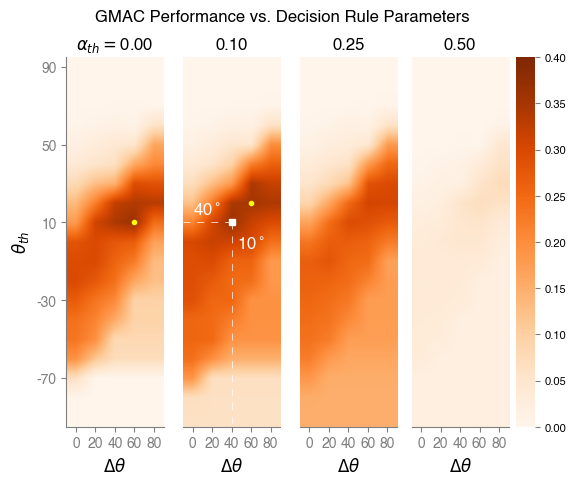

In [215]:
fig = plt.figure()
showinx = [1, 4, 5, 6]
for i, _amth in enumerate(gmac_param_ranges["am_th"]):
    ax = fig.add_subplot(1, len(showinx), i+1)
    # Create the heatmap using imshow
    _hm = ax.imshow(perf[i][::-1,:], cmap='Oranges', interpolation='bilinear',
                    vmin=0, vmax=0.4)
    if i == 0:
        ax.set_ylabel(r'$\theta_{th}$', fontsize=12)
        ax.set_yticks(np.arange(perf[0].shape[0]),
                      labels=gmac_param_ranges["p_th"][::-1],
                      color="tab:gray")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax.spines["left"].set_visible(True)
        ax.spines["left"].set_color("tab:gray")
        ax.yaxis.set_tick_params(color='tab:grey')
    else:
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_color("tab:gray")

    # Set x ticks
    ax.set_xticks(np.arange(perf[0].shape[1]),
                  labels=gmac_param_ranges["p_th_band"],
                  color="tab:gray")

    # Add labels to the axes
    ax.set_xlabel(r'$\Delta\theta$', fontsize=12)
    ax.xaxis.set_tick_params(color='tab:grey')

    # Plot the points with 95% of the max. performance
    if i in perfinx[0]:
        ax.plot(perfinx[2][i], perfinx[1][i], 'o', color='yellow', markersize=3)

    # Plot the max. point.
    if i == maxinx[0][0]:
        ax.plot(maxinx[2][0], maxinx[1][0], 's', color='white', markersize=5)
        ax.plot([maxinx[2][0], maxinx[2][0]],
                [maxinx[1][0], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
                linestyle='dashed', dashes=(10, 10),
                color='white')
        ax.plot([-0.5, maxinx[2][0]],
                [maxinx[1][0], maxinx[1][0]], lw=0.5,
                linestyle='dashed', dashes=(10, 10),
                color='white')
        # Show the max. argument
        ax.text(maxinx[2][0] - 1.25, maxinx[1][0] - 0.25,
                (f"{bestarg[2]:0.0f}"
                 + r"$^\circ$"),
                color='white', ha='center', va='bottom',
                fontsize=12)
        ax.text(maxinx[2][0] + 1, maxinx[1][0] + 1.5,
                (f"{bestarg[1]:0.0f}"
                 + r"$^\circ$"),
                color='white', ha='center', va='bottom',
                fontsize=12)
        # ax.text(maxinx[2][0] - 0.0, maxinx[1][0] - 0.25,
        #         (f"({bestarg[2]:0.0f}"
        #          + r"$^\circ$," 
        #          + f"{bestarg[1]:0.0f}"
        #          + r"$^\circ$)"),
        #         color='white', ha='center', va='bottom',
        #         fontsize=12)

    # Set the plot title
    if i == 0:
        ax.set_title(r'$\alpha_{th} = $' + f"{_amth:0.2f}")
    else:
        ax.set_title(f"{_amth:0.2f}")
    
    # Color map
    if i == len(gmac_param_ranges["am_th"]) - 1:
        _cbar = plt.colorbar(_hm)
        # Modify colorbar settings
        _cbar.ax.tick_params(labelsize=8)  # Set tick label font size
        # _cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Set custom tick positions
        # _cbar.set_ticklabels(['Low', 'Medium', 'High', 'Very High', 'Max'])  # Set custom tick labels
        _cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
        _cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
        _cbar.ax.yaxis.set_tick_params(color='tab:gray')


plt.suptitle("GMAC Performance vs. Decision Rule Parameters")
plt.subplots_adjust(wspace=-0.2)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")

In [214]:
# Get the performance of the left out subject for the best parameters.
_inx = ((gmac_perf.am_th == bestarg[0]) &
        (gmac_perf.am_th_band == 0) &
        (gmac_perf.p_th == bestarg[1]) &
        (gmac_perf.p_th_band == bestarg[2]))
nolooperf = {
    "youden": gmac_perf.loc[_inx, "youden"].values,
    "sensitivity": gmac_perf.loc[_inx, "sensitivity"].values,
    "specificity": gmac_perf.loc[_inx, "specificity"].values,
}

In [32]:
# How different is the maximum?
_perf = perf[:, :, :]
# Maximum performance
maxperf = np.max(_perf)
minperf = np.min(_perf)
_inx = (100 * (_perf - minperf) / (maxperf - minperf)) > 95
perfinx = np.where(_inx)
[np.array([gmac_param_ranges["am_th"][perfinx[0][i]],
           gmac_param_ranges["p_th"][perfinx[1][i]],
           gmac_param_ranges["p_th_band"][perfinx[2][i]]]) for i in range(len(perfinx[0]))]

[array([ 0, 10, 60]), array([ 0.1, 10. , 40. ]), array([ 0.1, 20. , 60. ])]

## Inter-subject GMAC Model with validation

In [33]:
# Leave-one-out validation
limbsubj = list(set(zip(gmac_perf.limb, gmac_perf.subject)))
# Get performance for the different parameters combinations.
perf = np.zeros((len(limbsubj),
                 len(gmac_param_ranges["am_th"]),
                 len(gmac_param_ranges["p_th"]),
                 len(gmac_param_ranges["p_th_band"])))
for l, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ~((gmac_perf.limb == _lmb) &
                (gmac_perf.subject == _subj))
    # Generate data for heatmap
    for i, _amth in enumerate(gmac_param_ranges["am_th"]):
        for j, _pth in enumerate(gmac_param_ranges["p_th"]):
            for k, _pthb in enumerate(gmac_param_ranges["p_th_band"]):
                _inx = ((gmac_perf.am_th == _amth) &
                        (gmac_perf.am_th_band == 0) &
                        (gmac_perf.p_th == _pth) &
                        (gmac_perf.p_th_band == _pthb))
                _vals = gmac_perf.loc[_looinx & _inx, "youden"].values
                sys.stdout.write(f"\r{l, i, j, k} ")
                # Computer performance
                _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
                perf[l, i, j, k] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))

(29, 3, 18, 4) 

In [34]:
# Find the best performning parameters in all these cases.
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf]).T[0].T
bestargs = np.array([(gmac_param_ranges["am_th"][_mxix[0]],
                      gmac_param_ranges["p_th"][_mxix[1]],
                      gmac_param_ranges["p_th_band"][_mxix[2]])
                     for _mxix in maxinx])
bestargs

array([[ 0. , 10. , 60. ],
       [ 0.1, 10. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0.1, 20. , 80. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 10. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0.1, 10. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 10. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0.1, 20. , 80. ],
       [ 0.1, 20. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0.1, 10. , 40. ],
       [ 0.1, 30. , 60. ],
       [ 0.1, 10. , 40. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ],
       [ 0. , 10. , 60. ]])

In [35]:
# Get the performance of the left out subject for the best parameters.
looperf = {
    "youden": np.zeros(len(limbsubj)),
    "sensitivity": np.zeros(len(limbsubj)),
    "specificity": np.zeros(len(limbsubj)),
}
for i, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    # Computer performance
    looperf["youden"][i] = np.percentile(gmac_perf.loc[_looinx & _inx, "youden"].values, 50)
    looperf["sensitivity"][i] = np.percentile(gmac_perf.loc[_looinx & _inx, "sensitivity"].values, 50)
    looperf["specificity"][i] = np.percentile(gmac_perf.loc[_looinx & _inx, "specificity"].values, 50)

#### Comparing performance with Subash et al. 2022

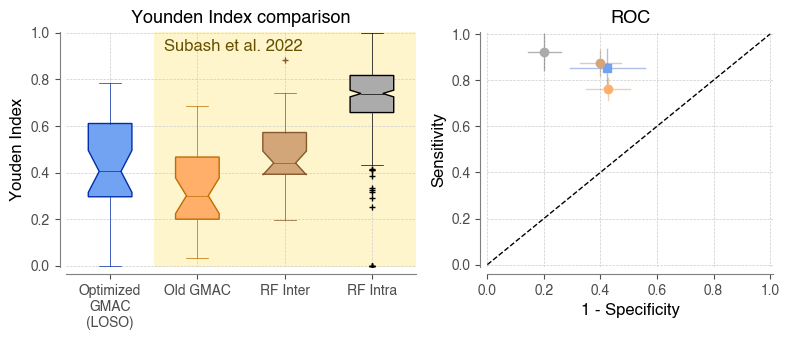

In [189]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
# _vals = np.hstack([curr_perf["youden"][i][j] for i in range(4)])
# j = 0
# ax.boxplot(x=nolooperf, positions=[j],
#         widths=0.5, notch=True, patch_artist=True,
#         boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
#         capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
#                         markerfacecolor=darkc[j], marker='+', markersize=4),
#         medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
j = 1
ax.boxplot(x=looperf["youden"], positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = looperf["sensitivity"]
_valspec = looperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [190]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

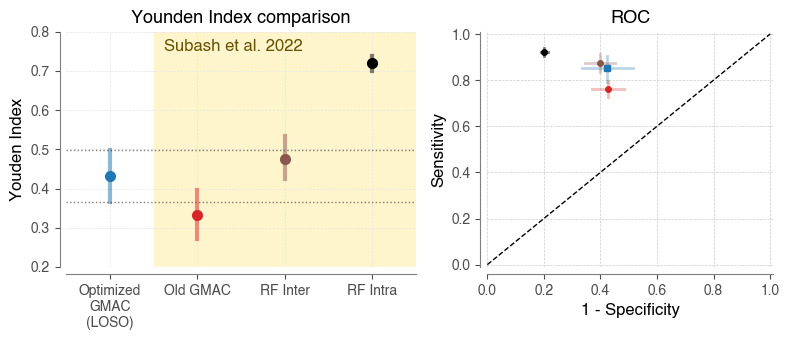

In [206]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(looperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = looperf["sensitivity"]
_valspec = looperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(looperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(looperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all.svg"), bbox_inches="tight")

#### Pairwise comparison with old GMAC

In [188]:
from scipy import stats

In [199]:
outcome = "specificity"

In [200]:
# Limbs
model = "GMAC"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = subash22df[_lmb][_minx & _sinx][outcome].values[0]
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")
# print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[GMAC], specificity
Not significant
0.003 $\pm$ 0.217


In [201]:
# Limbs
model = "RF inter"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = subash22df[_lmb][_minx & _sinx][outcome].values[0]
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[RF inter], specificity
Not significant
-0.024 $\pm$ 0.213


In [202]:
# Limbs
model = "RF intra"
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[], []]

# LOO Inter-Subject
for i, (_lmb, _subj) in enumerate(limbsubj):
    # LOO perf
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.am_th == bestargs[i][0]) &
            (gmac_perf.am_th_band == 0) &
            (gmac_perf.p_th == bestargs[i][1]) &
            (gmac_perf.p_th_band == bestargs[i][2]))
    _perf1 = gmac_perf[_inx & _looinx][outcome].values[0]
    # Subash perf
    _minx = subash22df[_lmb].method == model
    _sinx = (subash22df[_lmb]["subject"] == _subj)
    _perf2 = np.nanmean(subash22df[_lmb][_minx & _sinx][outcome].values)
    diff_perf[0].append(_perf1)
    diff_perf[1].append(_perf2)

# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(diff_perf[0], diff_perf[1])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
print(f"[{model}], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = np.array(diff_perf[0]) - np.array(diff_perf[1])
print(f"{np.nanmean(_diff):0.3f} $\\pm$ {np.nanstd(_diff):0.3f}")

[RF intra], specificity
0.000
-0.222 $\pm$ 0.259


### Compute GMAC for the best parameters

In [221]:
# GMAC Parameter ranges
gmac_param = {
    "np": int(Fs // 2),
    "fc": 0.1,
    "nc": 2,
    "nam": int(5*Fs),
    "p_th": 10,
    "p_th_band": 40,
    "am_th": 0.1,
    "am_th_band": 0
}

# Estimate pitch for each subject.
accl_cols = ['ax', 'ay', 'az']
dfcols = (["subject", "limb", "pitch", "am", "gmac", "gt"])
gmac_raw_df = pd.DataFrame(columns=dfcols)
for limbkey in ["left", "right", "aff", "unaff"]:
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()
    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        sys.stdout.write(f"\r{limbkey} {i:3d}")
        df = limbdf[limbdf.subject==subj]
        # Compute gmac
        _gmacout = [
            gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                params=gmac_param, full_output=True)
            for _, _df in df.groupby('segment')
        ]
        # Pitch
        _pitch = np.hstack([_gmac[0] for _gmac in _gmacout])
        _am = np.hstack([_gmac[1] for _gmac in _gmacout])
        _gmac = np.hstack([_gmac[2] for _gmac in _gmacout])
        _rawdf = pd.DataFrame(
            np.vstack([_pitch, _am, _gmac, df.gnd.values]).T,
            columns=["pitch", "am", "gmac", "gt"]
        )
        _rawdf["subject"] = subj
        _rawdf["limb"] = limbkey
        gmac_raw_df = pd.concat(
            (gmac_raw_df, _rawdf),
            ignore_index=True
        )

unaff   4

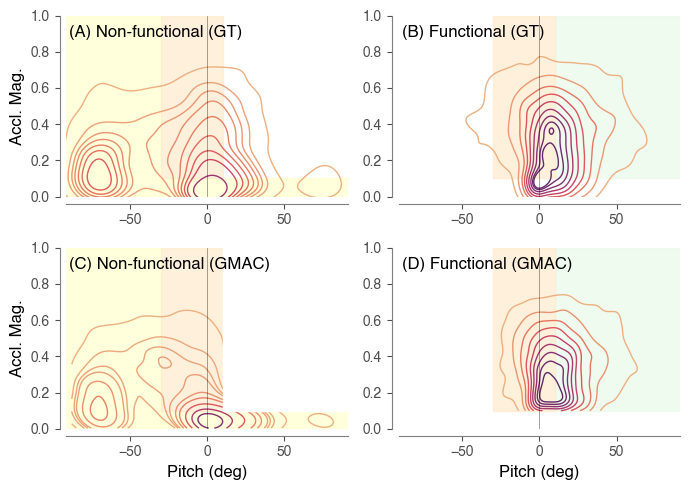

In [360]:
# Scatter plot of pitch vs. am for different classes
M = 100
fig = plt.figure(figsize=(7, 5))
# Ground truth
ax = plt.subplot(2, 2, 1)
# Backgrounds
# u = 0
background = plt.Rectangle((-100, 0), 70, 1.0,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
background = plt.Rectangle((-30, 0), 130, 0.1,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gt"] == 0
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Accl. Mag.", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 0$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(A) Non-functional (GT)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

ax = plt.subplot(2, 2, 2)
# Backgrounds
# u = 1
background = plt.Rectangle((10, 0.1), 90, 0.9,
                           transform=ax.transData,
                           color='#eafaea', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gt"] == 1
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_xlabel("Pitch (deg)", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 1$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(B) Functional (GT)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

# Actual GMAC
ax = plt.subplot(2, 2, 3)
# Backgrounds
# u = 0
background = plt.Rectangle((-100, 0), 70, 1.0,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
background = plt.Rectangle((-30, 0), 130, 0.1,
                           transform=ax.transData,
                           color='#ffffcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gmac"] == 0
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0,
            cut=0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5, zorder=3);
ax.set_xlabel("Pitch (deg)", fontsize=12)
ax.set_ylabel("Accl. Mag.", fontsize=12)
# ax.set_title(r"$u\left(t\right) = 0$", fontsize=13)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(C) Non-functional (GMAC)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)
background = plt.Rectangle((10, 0.1), 80, 1.0,
                           transform=ax.transData,
                           color='#fff', zorder=2)
ax.add_patch(background)

ax = plt.subplot(2, 2, 4)
# Backgrounds
# u = 1
background = plt.Rectangle((10, 0.1), 90, 0.9,
                           transform=ax.transData,
                           color='#eafaea', zorder=-1, alpha=0.7)
ax.add_patch(background)
# u = 0/1
background = plt.Rectangle((-30, 0.1), 40, 0.9,
                           transform=ax.transData,
                           color='#ffebcc', zorder=-1, alpha=0.7)
ax.add_patch(background)
_inx = gmac_raw_df["gmac"] == 1
sns.kdeplot(x=gmac_raw_df.loc[_inx, "pitch"].values[::M],
            y=gmac_raw_df.loc[_inx, "am"].values[::M],
            levels=10, cmap='flare', linewidths=1.0,
            cut=0)
ax.axvline(x=0, lw=0.5, color="black", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("Pitch (deg)", fontsize=12)
ax.set_xlim(-91, 91)
ax.set_ylim(0.0, 1.0)
ax.text(0.01, 0.95, "(D) Functional (GMAC)", ha="left", va="top", fontsize=12,
        color="#000", transform=ax.transAxes,)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gt_gmac_hist_contours.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gt_gmac_hist_contours.svg"), bbox_inches="tight")

## Intra-subject GMAC Model with validation
Compute the peformanance for each subject for each parameter combination across
the different segments.

In [86]:
perf = np.zeros((len(limbsubj),
                 len(gmac_param_ranges["am_th"]),
                 len(gmac_param_ranges["p_th"]),
                 len(gmac_param_ranges["p_th_band"])))

In [101]:
segs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [155]:
# Find the best parameter for each subject and each limb.
segs = gmac_perf_intra.segment.unique()
_inx1 = (gmac_perf_intra.am_th_band == 0)
for l, (limb, subj) in enumerate(limbsubj):
    linx = (gmac_perf_intra.limb == limb)
    sinx = (gmac_perf_intra.subject == subj)
    trinx = (gmac_perf_intra.type == "train")
    # Go through each parameter combination
    _youden = np.zeros((10,
                        len(gmac_param_ranges["am_th"]),
                        len(gmac_param_ranges["p_th"]),
                        len(gmac_param_ranges["p_th_band"])))
    for i, _amth in enumerate(gmac_param_ranges["am_th"]):
        _inx2 = (gmac_perf_intra.am_th == _amth)
        for j, _pth in enumerate(gmac_param_ranges["p_th"]):
            _inx3 = (gmac_perf_intra.p_th == _pth)
            for k, _pthb in enumerate(gmac_param_ranges["p_th_band"]):
                _inx4 = (gmac_perf_intra.p_th_band == _pthb)
                for m, seg in enumerate(segs):
                    _inx = (linx & sinx &  trinx & 
                            _inx1 & _inx2 & _inx3 & _inx4 &
                            (gmac_perf_intra.segment == seg))
                    _youden[m, i, j, k] = gmac_perf_intra.loc[_inx, "youden"].values[0]
                    sys.stdout.write(f"\r{l, i, j, k, m} ")
    # Compute the perforamance across segments for all parameter combinations.
    _youdsumm = [np.nanpercentile(_youden, q, axis=0) for q in [25, 50, 75]]
    perf[l, :, :, :] = _youdsumm[1] * (1 - (_youdsumm[2] - _youdsumm[0]))

(29, 3, 18, 4, 9) 

In [156]:
# Find the best parameters for each subject.
maxinx = np.array([np.array(np.where(_perf == np.max(_perf))).T[0] for _perf in perf])
bestargs = np.array([(gmac_param_ranges["am_th"][_mxix[0]],
                      gmac_param_ranges["p_th"][_mxix[1]],
                      gmac_param_ranges["p_th_band"][_mxix[2]])
                     for _mxix in maxinx])
bestargs

array([[  0.  ,  20.  ,  80.  ],
       [  0.1 ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  40.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.1 ,  10.  ,  40.  ],
       [  0.1 ,  20.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.  ,  20.  ,  40.  ],
       [  0.  ,  10.  ,  20.  ],
       [  0.  ,  20.  ,  80.  ],
       [  0.25, -30.  ,   0.  ],
       [  0.1 ,  20.  ,  80.  ],
       [  0.1 ,   0.  ,  20.  ],
       [  0.1 ,   0.  ,  20.  ],
       [  0.1 ,  40.  ,  40.  ],
       [  0.  ,   0.  ,  40.  ],
       [  0.  ,  40.  ,  80.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.  ,  20.  ,  40.  ],
       [  0.  ,  10.  ,  40.  ],
       [  0.1 , -10.  ,  20.  ],
       [  0.1 ,  20.  ,  40.  ],
       [  0.  ,  20.  ,  60.  ],
       [  0.1 ,   0.  ,  20.  ]])

In [157]:
# Get the performance of the left out subject for the best parameters.
kfoldperf = {
    "youden": np.zeros(len(limbsubj)),
    "sensitivity": np.zeros(len(limbsubj)),
    "specificity": np.zeros(len(limbsubj)),
}
for i, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _kfinx = ((gmac_perf_intra.limb == _lmb) &
               (gmac_perf_intra.subject == _subj) &
               (gmac_perf_intra.type != "train"))
    _inx = ((gmac_perf_intra.am_th == bestargs[i][0]) &
            (gmac_perf_intra.am_th_band == 0) &
            (gmac_perf_intra.p_th == bestargs[i][1]) &
            (gmac_perf_intra.p_th_band == bestargs[i][2]))
    # Computer performance
    kfoldperf["youden"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "youden"].values, 50)
    kfoldperf["sensitivity"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "sensitivity"].values, 50)
    kfoldperf["specificity"][i] = np.nanpercentile(gmac_perf_intra.loc[_kfinx & _inx, "specificity"].values, 50)

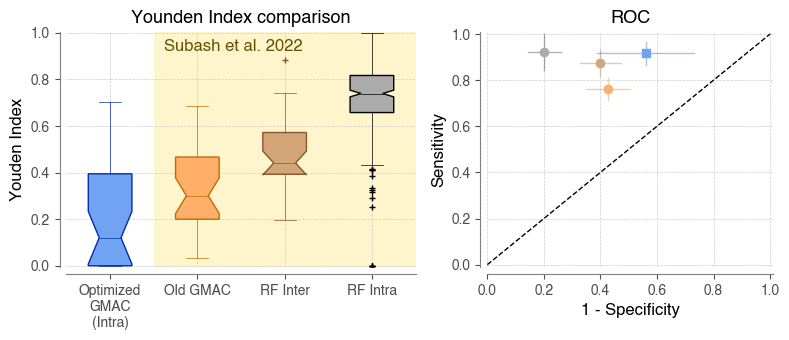

In [161]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
# _vals = np.hstack([curr_perf["youden"][i][j] for i in range(4)])
# j = 0
# ax.boxplot(x=nolooperf, positions=[j],
#         widths=0.5, notch=True, patch_artist=True,
#         boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
#         capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
#         flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
#                         markerfacecolor=darkc[j], marker='+', markersize=4),
#         medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
j = 1
ax.boxplot(x=kfoldperf["youden"], positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(Intra)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = kfoldperf["sensitivity"]
_valspec = kfoldperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()